In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import pycountry
import pickle
import us

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer 

from gensim.models import Word2Vec

from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

%matplotlib inline

%config IPCompleter.greedy=True

pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/linhnguyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/linhnguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/linhnguyen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Take a look at the output
stimulus_raw = pd.read_csv("stimulus_raw.csv")

# Print the first five rows
display(stimulus_raw.head())

# Print the summary statistics
print(stimulus_raw.describe())

# Print the info
print(stimulus_raw.info())

,Unnamed: 0,Unnamed: 0.1,Content,Location,Username,Retweet-Count,Favorites,Created at
0,0,0,@ZupancicJareen Follow #BidenLies #BidenLied and #BidenRemorse and #BidenRegret,NaN,Trish22758076,0,0,2021-03-30 22:59:04
1,1,1,Link to get :👇👇👇\nhttps://t.co/kRoIosUS6y\n#Trump2024 #Trump #fuckbiden #BidenLied #Republicans #Republican #MAGA2024 #AmericanIdol #USA #NewYork #newyorkpost #Florida #Texas #Washington #California #NativeAmerican #Patriot #patriots https://t.co/7AWhzGO0HQ,Etats-Unis,Hicham21940587,1,0,2021-03-30 22:48:48
2,2,2,#Trump 🇺🇸\nWaPo Fact-Checkers Slam #BidenLied for Georgia Election Law Claims: ‘Four Pinocchios’ https://t.co/k1lvAUdrPg,"Hyères, France",C_W_UK,0,0,2021-03-30 22:47:54
3,3,3,YouTube doing away with dislikes bc of Whitehouse and You Social Justice CeeUNextTuesdays.\n#youtubehelp #BidenLied #SocialJusticeWorriers #LiberalismIsTheRealPandemic #dislikes #vaccine #POTUS #BidenOfBones #JoeBiden shill prez #JoeBidenDown #stevencrowder #crowderchauvinstream,"Clown World, USA",BEcAMearekonING,0,0,2021-03-30 22:46:12
4,4,4,"Everyone knows this is happening to protect #Biden.\n\nAnything he does gets slaughtered on YouTube, because that's the truth, and they can't handle the damage anymore.\n\nNext stop: Vax Passports, Censorship, and Information Suppression\n\n#BidenLied #Trump2024 https://t.co/w41AA28Dkj",NaN,BilukCyril,0,0,2021-03-30 22:39:17


        Unnamed: 0  Unnamed: 0.1  Retweet-Count     Favorites
count  8084.000000   8084.000000    8084.000000   8084.000000
mean   4041.500000    716.413409       2.830901     11.922934
std    2333.794121    435.993453     117.158487    552.269555
min       0.000000      0.000000       0.000000      0.000000
25%    2020.750000    336.000000       0.000000      0.000000
50%    4041.500000    691.000000       0.000000      0.000000
75%    6062.250000   1095.000000       0.000000      2.000000
max    8083.000000   1499.000000   10016.000000  47094.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8084 entries, 0 to 8083
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     8084 non-null   int64 
 1   Unnamed: 0.1   8084 non-null   int64 
 2   Content        8084 non-null   object
 3   Location       5682 non-null   object
 4   Username       8084 non-null   object
 5   Retweet-Count  8084 non-null  

In [4]:
#We don't need the 2 columns called Unnamed, we're gonna drop them. Also, we will remove duplicated tweets. 
stimulus_raw.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], axis=1, inplace=True)

# Drop duplicated rows
stimulus_raw.drop_duplicates(inplace=True)

# Created at column's type should be datatime
stimulus_raw["Created at"] = pd.to_datetime(stimulus_raw["Created at"])

# Print the info again
print(stimulus_raw.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7696 entries, 0 to 8083
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Content        7696 non-null   object        
 1   Location       5414 non-null   object        
 2   Username       7696 non-null   object        
 3   Retweet-Count  7696 non-null   int64         
 4   Favorites      7696 non-null   int64         
 5   Created at     7696 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 420.9+ KB
None


In [5]:
# Now we clean up the content of the tweets. We'll remove stopwords, punctuation, mention, hashtag, links, and one-or-two letter words lik a or an
#After that, we'll tokenize the tweets
def clean_up(tweet):
    
    # Remove links
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    
    # Remove mentions and hashtag
    tweet = re.sub(r'\@\w+|\#','', tweet)
    
    # Tokenize the words
    tokenized = word_tokenize(tweet)

    # Remove the stop words
    tokenized = [token for token in tokenized if token not in stopwords.words("english")] 

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokenized = [lemmatizer.lemmatize(token, pos='a') for token in tokenized]

    # Remove non-alphabetic characters and keep the words contains three or more letters
    tokenized = [token for token in tokenized if token.isalpha() and len(token)>2]
    
    return tokenized
    
# Call the function and store the result into a new column
stimulus_raw["Processed"] = stimulus_raw["Content"].str.lower().apply(clean_up)


# Print the first fifteen rows of Processed
display(stimulus_raw[["Processed"]].head(15))

,Processed
0,"[follow, bidenlies, bidenlied, bidenremorse, bidenregret]"
1,"[link, get, trump, fuckbiden, bidenlied, republicans, republican, americanidol, usa, newyork, newyorkpost, florida, texas, washington, california, nativeamerican, patriot, patriots]"
2,"[trump, wapo, slam, bidenlied, georgia, election, law, claims, four, pinocchios]"
3,"[youtube, away, dislikes, whitehouse, social, justice, ceeunexttuesdays, youtubehelp, bidenlied, socialjusticeworriers, liberalismistherealpandemic, dislikes, vaccine, potus, bidenofbones, joebiden, shill, prez, joebidendown, stevencrowder, crowderchauvinstream]"
4,"[everyone, knows, happening, protect, biden, anything, gets, slaughtered, youtube, truth, handle, damage, anymore, next, stop, vax, passports, censorship, information, suppression, bidenlied]"
5,"[kidsincages, good, kidsincages, racist, good, racist, rapist, good, rapist, hunterbiden, good, never, mind, dog, major, adorable, cat, bidenlied, impeachbiden]"
6,"[kidsincages, good, kidsincages, racist, good, racist, rapist, good, rapist, hunterbiden, good, dog, major, maga, hey, cat, bidenlied, impeachbiden]"
7,"[never, seen, anyone, protect, person, like, big, tech, biden, bordercrisis, bidenlied, control, informationwar]"
8,"[tired, imposed, kids, school, sick, america, last, policies, dare, flood, country, illegals, even, taking, care, children, disgust, bidenlied, bidenbordercrisis, bidenamericalast]"
9,"[stopaapihate, abcnews, cnn, hannity, tuckercarlson, americafirst, foxnews, oann, newsmax, thefive, cancelculture, woke, blacklivesmatter, antifa, bidenlied, biden, stopasianhate, biden, msnbc, dare, point, truth, hehe]"


In [6]:
#We record the length of the tweets and the number of words in each tweets in new columns
# Get the tweet lengths
stimulus_raw["Length"] = stimulus_raw["Content"].str.len()

# Get the number of words in tweets
stimulus_raw["Words"] = stimulus_raw["Content"].str.split().str.len()

# Display the new columns
display(stimulus_raw[["Length", "Words"]])

,Length,Words
0,79,8
1,255,24
2,119,14
3,278,27
4,280,37
...,...,...
8079,104,15
8080,155,22
8081,140,18
8082,52,6


In [7]:
#we want to record the locations of the tweet, so that maybe we can analyze how people from different regions feel about this stimulus check.
#we'll store the location of the tweet to a column. If there's no location found, we'll mark it as 'unknown'
stimulus_raw["Location"].fillna("unknown", inplace=True)

# Print the unique locations and number of unique locations
print("Unique Values:",stimulus_raw["Location"].unique())
print("Unique Value count:",len(stimulus_raw["Location"].unique()))

Unique Values: ['unknown' 'Etats-Unis' 'Hyères, France' ... 'PHL, PA' 'Kansas, USA'
 'Tennessee']
Unique Value count: 2043


In [25]:
# After recording the locations, we want to classify the locations that are states within the US versus foreign countries.
def get_countries(location):
    
    # If location is a country name return its alpha2 code
    if pycountry.countries.get(name= location):
        return pycountry.countries.get(name = location).alpha_2
    
    # If location is a subdivisions name return the countries alpha2 code
    try:
        pycountry.subdivisions.lookup(location)
        return pycountry.subdivisions.lookup(location).country_code
    except:
        # If the location is neither country nor subdivision return the "unknown" tag
        return "unknown"

# Call the function and store the country codes in the Country column
stimulus_raw["Country"] = stimulus_raw["Location"].apply(get_countries)

# Print the unique values
print(stimulus_raw["Country"].unique())

# Print the number of unique values
print("Number of unique values:",len(stimulus_raw["Country"].unique()))


['unknown' 'US' 'GE' 'FR' 'CU' 'CA' 'EG' 'IE' 'HK' 'BS' 'LU' 'AU' 'IL'
 'GB' 'SG' 'MY' 'NL' 'DZ' 'GT' 'NZ' 'AQ' 'ES' 'NG' 'JM' 'DE' 'LR' 'NI'
 'JP' 'UG' 'DK' 'CR' 'UM']
Number of unique values: 32


In [26]:
def get_states(location):
    
    # If location is a US state name return its alpha2 code
    if us.states.lookup(location):
        state = us.states.lookup(location)
        return state.abbr
    
    # If location is not a us state, return not-us or unknown
    try:
        pycountry.subdivisions.lookup(location)
        return "not-us"
    except:
        # If the location is neither country nor subdivision return the "unknown" tag
        return "unknown"

# Call the function and store the country codes in the Country column
stimulus_raw["States"] = stimulus_raw["Location"].apply(get_states)

# Print the unique values
print(stimulus_raw["States"].unique())

# Print the number of unique values
print("Number of unique values:",len(stimulus_raw["States"].unique()))

['unknown' 'GA' 'OK' 'ME' 'CT' 'OH' 'not-us' 'TX' 'WI' 'AR' 'FL' 'MN' 'PA'
 'IA' 'LA' 'NY' 'MI' 'IL' 'OR' 'NJ' 'KY' 'NH' 'SC' 'MA' 'KS' 'WV' 'CA'
 'AL' 'IN' 'CO' 'NV' 'MO' 'VA' 'DE' 'NM' 'SD' 'AZ' 'HI' 'WA' 'MD' 'NC'
 'DC' 'MS' 'VT' 'AK' 'TN']
Number of unique values: 46


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [9]:
from gensim.models import Word2Vec

In [10]:
stimulus_processed = pd.read_csv("stimulusProcessed.csv")
display(stimulus_processed.head())
print(stimulus_raw.describe())

,Unnamed: 0,Content,Location,Username,Retweet-Count,Favorites,Created at,Processed,Length,Words,Country,States
0,0,@ZupancicJareen Follow #BidenLies #BidenLied and #BidenRemorse and #BidenRegret,unknown,Trish22758076,0,0,3/30/21 22:59,"['follow', 'bidenlies', 'bidenlied', 'bidenremorse', 'bidenregret']",79,8,unknown,unknown
1,1,Link to get :👇👇👇\nhttps://t.co/kRoIosUS6y\n#Trump2024 #Trump #fuckbiden #BidenLied #Republicans #Republican #MAGA2024 #AmericanIdol #USA #NewYork #newyorkpost #Florida #Texas #Washington #California #NativeAmerican #Patriot #patriots https://t.co/7AWhzGO0HQ,Etats-Unis,Hicham21940587,1,0,3/30/21 22:48,"['link', 'get', 'trump', 'fuckbiden', 'bidenlied', 'republicans', 'republican', 'americanidol', 'usa', 'newyork', 'newyorkpost', 'florida', 'texas', 'washington', 'california', 'nativeamerican', 'patriot', 'patriots']",255,24,unknown,unknown
2,2,#Trump 🇺🇸\nWaPo Fact-Checkers Slam #BidenLied for Georgia Election Law Claims: ‘Four Pinocchios’ https://t.co/k1lvAUdrPg,"Hyères, France",C_W_UK,0,0,3/30/21 22:47,"['trump', 'wapo', 'slam', 'bidenlied', 'georgia', 'election', 'law', 'claims', 'four', 'pinocchios']",119,14,unknown,unknown
3,3,YouTube doing away with dislikes bc of Whitehouse and You Social Justice CeeUNextTuesdays.\n#youtubehelp #BidenLied #SocialJusticeWorriers #LiberalismIsTheRealPandemic #dislikes #vaccine #POTUS #BidenOfBones #JoeBiden shill prez #JoeBidenDown #stevencrowder #crowderchauvinstream,"Clown World, USA",BEcAMearekonING,0,0,3/30/21 22:46,"['youtube', 'away', 'dislikes', 'whitehouse', 'social', 'justice', 'ceeunexttuesdays', 'youtubehelp', 'bidenlied', 'socialjusticeworriers', 'liberalismistherealpandemic', 'dislikes', 'vaccine', 'potus', 'bidenofbones', 'joebiden', 'shill', 'prez', 'joebidendown', 'stevencrowder', 'crowderchauvinstream']",278,27,unknown,unknown
4,4,"Everyone knows this is happening to protect #Biden.\n\nAnything he does gets slaughtered on YouTube, because that's the truth, and they can't handle the damage anymore.\n\nNext stop: Vax Passports, Censorship, and Information Suppression\n\n#BidenLied #Trump2024 https://t.co/w41AA28Dkj",unknown,BilukCyril,0,0,3/30/21 22:39,"['everyone', 'knows', 'happening', 'protect', 'biden', 'anything', 'gets', 'slaughtered', 'youtube', 'truth', 'handle', 'damage', 'anymore', 'next', 'stop', 'vax', 'passports', 'censorship', 'information', 'suppression', 'bidenlied']",280,37,unknown,unknown


       Retweet-Count     Favorites       Length        Words
count    7696.000000   7696.000000  7696.000000  7696.000000
mean        2.961279     12.483888   197.392672    29.729860
std       120.074296    566.015791    82.895401    13.702527
min         0.000000      0.000000    19.000000     2.000000
25%         0.000000      0.000000   127.000000    18.000000
50%         0.000000      0.000000   204.000000    30.000000
75%         0.000000      2.000000   272.000000    41.000000
max     10016.000000  47094.000000   957.000000    97.000000


In [11]:
from sklearn.feature_extraction.text import CountVectorizer


In [12]:

tfidf_stops =["stimulus", "check", "stimulus check", "biden", "bidenlied"]



vectorizer = TfidfVectorizer(max_df =0.85,max_features=5, stop_words= tfidf_stops)

tfidf_matrix = vectorizer.fit_transform(stimulus_processed["Processed"])
display(tfidf_matrix)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns= vectorizer.get_feature_names())
display(tfidf_df.head())

<7696x5 sparse matrix of type '<class 'numpy.float64'>'
	with 5007 stored elements in Compressed Sparse Row format>

,amp,get,lalate,lied,stimuluscheck
0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


In [139]:
#Explore the data

In [140]:
# Print the minimum datetime
print("Since:",stimulus_processed["Created at"].min())

# Print the maximum datetime
print("Until",stimulus_processed["Created at"].max())

Since: 2021-03-23 03:40:38
Until 2021-03-30 23:04:13


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


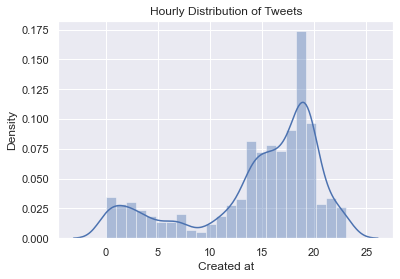

In [141]:
sns.set()

# Plot the histogram of hours
sns.distplot(stimulus_raw["Created at"].dt.hour, bins=24)
plt.title("Hourly Distribution of Tweets")
plt.show()

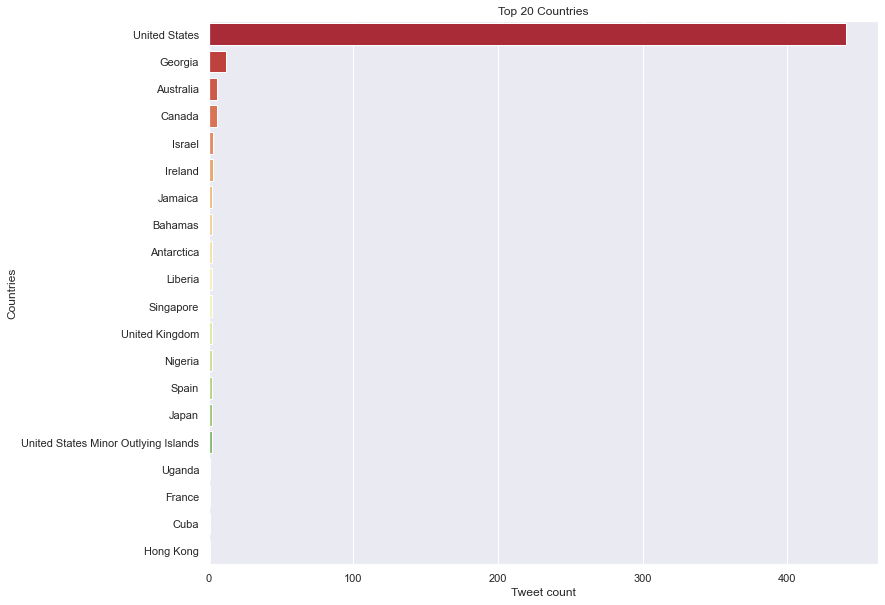

In [142]:
countries = stimulus_raw[stimulus_raw.Country!='unknown']

# Select the top 20 countries
top_countries = countries["Country"].value_counts(sort=True).head(20)

# Convert alpha2 country codes to country names and store in a list
country_fullnames = []
for alpha2 in top_countries.index:
    country_fullnames.append(pycountry.countries.get(alpha_2=alpha2).name)

# Visualize the top 20 countries
plt.figure(figsize=(12,10))
sns.barplot(y=country_fullnames,x=top_countries, orient="h", palette="RdYlGn")
plt.xlabel("Tweet count")
plt.ylabel("Countries")
plt.title("Top 20 Countries")
plt.show()


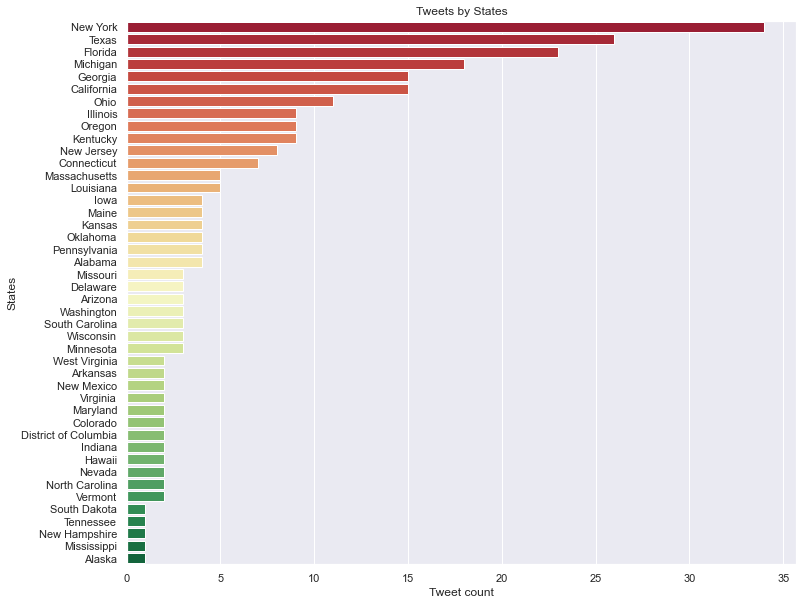

In [143]:
states = stimulus_raw[stimulus_raw.States!='unknown']

# Select 50 states
top_states = states["States"].value_counts(sort=True).head(50)

# Convert alpha2 country codes to country names and store in a list
states_fullnames = []
for alpha2 in top_states.index:
    states_fullnames.append(us.states.lookup(alpha2))

# Visualize the top 20 countries
plt.figure(figsize=(12,10))
sns.barplot(y=states_fullnames,x=top_states, orient="h", palette="RdYlGn")
plt.xlabel("Tweet count")
plt.ylabel("States")
plt.title("Tweets by States")
plt.show()

In [144]:
# Display the most popular tweets
display(stimulus_raw.sort_values(by=["Favorites","Retweet-Count", ], axis=0, ascending=False)[["Content","Retweet-Count","Favorites"]].head(20))

,Content,Retweet-Count,Favorites
7552,Biden’s son lied about his drug use on his form to obtain a firearm. \n\nDo you believe he will be prosecuted?,10016,47094
6746,"Let me get this straight. Biden is being criticized by the right for using notes. Which I do, and Reagan did, when you want to get it right. Trump didn’t use notes and lied on average 21 x a day. I don’t know, put me down as notes = truth.",2904,15056
8061,"Also, don’t forget the part about the unofficially assigned Secret Service trying to seize the form on which Hunter Biden lied so there wasn’t a record of him lying on the form. In other words, to make it difficult to prosecute him. https://t.co/IogxYd8mcq",732,2153
7616,Biden’s already bombed Syria &amp; refuses to end the wars.\n\nHe’s issued 31 drilling permits &amp; refuses to ban fracking.\n\nHe lied about $2000 checks &amp; refuses to fight for $15.\n\nAnd there’s still kids in cages so no socialists are not “bad faith actors” for saying nothing has changed.,617,2033
7291,Eric Trump says he'd be in jail for allegedly lying like Hunter Biden over gun scandal https://t.co/QwJ5k7PTmv https://t.co/heNJNGNWUM,427,2018
6799,"Buttiegieg LIES to CNN: “If you make less than $400k a year, this proposal will not involve a tax increase for you.”\n\nBiden LIED to ABC saying “if you make less than $400k you won’t see a penny increase.\n\nWouldn’t it be nice if these “reporters” actually understood taxes.",318,1315
7734,"ICYMI, Hunter Biden lied twice on his 4473 to illegally obtain a firearm, then ⁦@JoeBiden⁩ had the FBI and Secret Service cover up him losing the gun during a drug fueled domestic violence incident. https://t.co/a9dtn5qf6Q",738,1305
7647,"Left-wing fact checker, Politifact, says Biden lied about border crises.\nhttps://t.co/JkVdcZ9dce",354,1229
6765,This is happening under @JoeBiden. This is happening is under Joe Biden. \nThis is happening is under Joe Biden. \nThis is happening is under Joe Biden. \nThis is happening is under Joe Biden. \nThis is happening is under Joe Biden. \n\nAOC lied. \nAOC lied. \nAOC lied. \nAOC lied. https://t.co/ySMaJchWXo,215,799
7213,"Biden lied about getting water in line when you're voting in Georgia. People representing a political party or candidate can't give out water to voters, but poll workers can. This should have been immediately fact checked by the media when Biden first lied about it.",289,701


In [145]:
frequencies = pd.DataFrame(tfidf_matrix.sum(axis=0).T,index=vectorizer.get_feature_names(),columns=['total frequency'])

# Sort the words by frequency
frequencies.sort_values(by='total frequency',ascending=False, inplace=True)
frequencies.to_csv("stimulus_frequency.csv")
# Display the most 20 frequent words
display(frequencies.head(200))

,total frequency
people,327.567103
still,309.371530
lalate,299.568191
money,247.200162
ssi,219.639457
...,...
defend,32.608860
random,32.210724
defending,32.197539
holiday,29.516339


In [146]:
#Sentiment Analysis

In [13]:
from textblob import TextBlob

In [14]:
m=stimulus_processed["Processed"].apply(lambda x: ' '.join(x))
stimulus_processed["Polarity"] = stimulus_processed["Processed"].apply(lambda word: TextBlob(word).sentiment.polarity)
stimulus_processed["Subjectivity"] = stimulus_processed["Processed"].apply(lambda word: TextBlob(word).sentiment.subjectivity)

# Display the Polarity and Subjectivity columns
display(stimulus_processed[["Polarity","Subjectivity"]].head(10))

,Polarity,Subjectivity
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,0.033333,0.066667
4,0.000000,0.000000
5,0.560417,0.650000
6,0.572500,0.580000
7,0.000000,0.100000
8,-0.371429,0.541270
9,0.000000,0.000000


In [15]:
def analyse_polarity(polarity):
    if polarity > 0:
        return "Positive"
    if polarity == 0:
        return "Neutral"
    if polarity < 0:
        return "Negative"

# Apply the funtion on Polarity column and add the results into a new column
stimulus_processed["Label"] = stimulus_processed["Polarity"].apply(analyse_polarity)

# Display the Polarity and Subjectivity Analysis
display(stimulus_processed[["Label"]].head(10))

,Label
0,Neutral
1,Neutral
2,Neutral
3,Positive
4,Neutral
5,Positive
6,Positive
7,Neutral
8,Negative
9,Neutral


In [16]:
print(stimulus_processed["Label"].value_counts())

Positive    3162
Neutral     2533
Negative    2001
Name: Label, dtype: int64


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


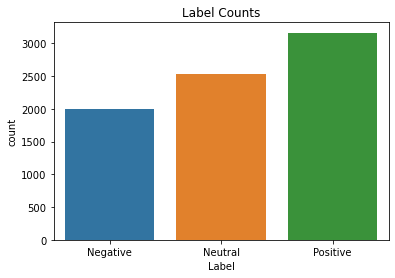

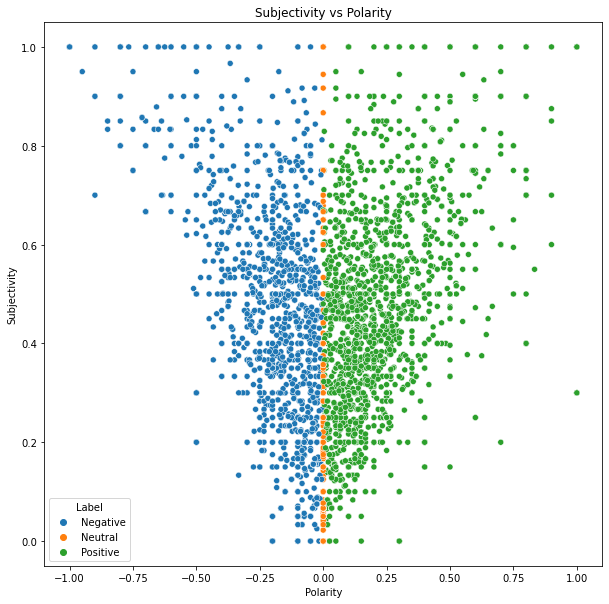

In [17]:
stimulus_processed["Label"] = stimulus_processed["Label"].astype("category")

# Visualize the Label counts
sns.countplot(stimulus_processed["Label"])
plt.title("Label Counts")
plt.show()

# Visualize the Polarity scores
plt.figure(figsize = (10, 10)) 
sns.scatterplot(x="Polarity", y="Subjectivity", hue="Label", data=stimulus_processed)
plt.title("Subjectivity vs Polarity")
plt.show()

In [18]:
display(stimulus_processed.sort_values(by=["Polarity","Favorites","Retweet-Count", ], axis=0, ascending=[False, False, False])[["Content","Retweet-Count","Favorites","Polarity"]].head(20))

# Display the negative tweets
display(stimulus_processed.sort_values(by=["Polarity", "Favorites", "Retweet-Count"], axis=0, ascending=[True, False, False])[["Content","Retweet-Count","Favorites","Polarity"]].head(20))

,Content,Retweet-Count,Favorites,Polarity
2207,Excellent column by our Founder @rainforestbook with his advice on how states should invest the $10B in federal stimulus money coming to them to get the most out of it. #RighttoStart #Stimulus #Investing https://t.co/P5lnuQN4jv,2,6,1.0
2930,"And because i am fed up of moronic liar #Biden\n\n#America also oozing a ton of #CO2 and methane\nPerfect timing for 5 trillions #stimulus\nbecause he ""follows the science"" \n\nFACTS ON THE GROUND\n\n25.03.2021\n#ClimateCrisis #climatechange #globalwarming #NetZero https://t.co/TVoC7jsirY",0,5,1.0
6726,@JordanSchachtel My position is you are an airhead. Dr Fauci is awesome and helped our country come out of a death grip by the other guy who lied and hid the truth from us. \n\nThank God for President Biden for getting the vaccine out to us and even got money for Americans and the States!,0,4,1.0
2202,What a wonderful front page of climate news we have today! \n\n⁦@nytimes⁩ #stimulus #offshorewind https://t.co/6lBBO2pqrS,1,3,1.0
2724,"#America also oozing a ton of #methane\nPerfect timing for 5 trillions #stimulus\nbecause we ""follow the science"" \n\n26.03.2021\n#ClimateCrisis #climatechange #globalwarming #NetZero https://t.co/DMufH4kQmW",0,3,1.0
4768,"@pulte Well because you can sounds like a superb reason to bless my cashapp. Still waiting on that stimulus check, but I've still got bills to catch up on. \n\n$essenceoffiona",0,2,1.0
202,"@FoxNews @tedcruz @POTUS Biden's handlers tweeted just yesterday ""If you have the best ideas, you have nothing to hide.""\nIt looks like he's not a man of his word, AGAIN. #BidenLied",0,1,1.0
2369,@JoeBiden the best #stimulus package is 0% income tax.,0,1,1.0
157,Excellent Hashtag I say 💁🏻‍♀️ #PassitOn @SenTedCruz @GovRonDeSantis @RonJohnsonWI @TheRealJoePound @catturd2 @KristySwansonXO @ksorbs @GOPLeader @jimmy_dore @TuckerCarlson @RepMattGaetz @larryelder @RealDeanCain #WeveGotACountryToSave #BidenLied #SaveOurCountry https://t.co/IKE4mlH3oM,1,0,1.0
3195,Got your #stimulus check? refund? What is the best way to use that #money #stimuluscheck #refund\n\nhttps://t.co/gisMuI1FuG\nhttps://t.co/SYDv8C8XYe https://t.co/SQIiSQEeRE,1,0,1.0


,Content,Retweet-Count,Favorites,Polarity
124,"@TimRunsHisMouth The shepherd doesn't lie to the sheep, it's the evil master.😳 #BidenLied",1,8,-1.0
674,THE SHOCKING VIDEO (@ 20 MINUTE MARK)!\n\nNOW PLAYING TUNE IN!!! SHARE + SUBSCRIBE ! \n\n🌙 OVERNIGHT LALATE 🌙 #EIDL\ntune in! ▶️▶️ https://t.co/hF29OZ7ZFX\n\n🎥 #LALATE 💜 #PURPLEPOWER 💜 #SEATS4STIMULUS 🗳️ #FPUCRETRO 💵 #MSC\n#stimuluscheck\n#stimuluschecks \n#SS200 10,1,6,-1.0
3506,Blow up this ass holes Twitter. Disgusting! #stimulus #ssi #SSDI #junkie https://t.co/G0XPXHFtTw,0,3,-1.0
653,THE SHOCKING VIDEO (@ 20 MINUTE MARK)!\n\nNOW PLAYING TUNE IN!!! SHARE + SUBSCRIBE ! \n\n🌙 OVERNIGHT LALATE 🌙 #EIDL\ntune in! ▶️▶️ https://t.co/hF29OZ7ZFX\n\n🎥 #LALATE 💜 #PURPLEPOWER 💜 #SEATS4STIMULUS 🗳️ #FPUCRETRO 💵 #MSC\n#stimuluscheck\n#stimuluschecks \n#SS200 11,0,2,-1.0
754,THE SHOCKING VIDEO (@ 20 MINUTE MARK)!\n\nNOW PLAYING TUNE IN!!! SHARE + SUBSCRIBE ! \n\n🌙 OVERNIGHT LALATE 🌙 #EIDL\ntune in! ▶️▶️ https://t.co/hF29OZ7ZFX\n\n🎥 #LALATE 💜 #PURPLEPOWER 💜 #SEATS4STIMULUS 🗳️ #FPUCRETRO 💵 #MSC\n#stimuluscheck\n#stimuluschecks \n#SS200 1,0,2,-1.0
759,THE SHOCKING VIDEO (@ 20 MINUTE MARK)!\n\nNOW PLAYING TUNE IN!!! SHARE + SUBSCRIBE ! \n\n🌙 OVERNIGHT LALATE 🌙 #EIDL\ntune in! ▶️▶️ https://t.co/hF29OZ7ZFX\n\n🎥 #LALATE 💜 #PURPLEPOWER 💜 #SEATS4STIMULUS 🗳️ #FPUCRETRO 💵 #MSC\n#stimuluscheck\n#stimuluschecks \n#SS200,0,2,-1.0
809,THE SHOCKING VIDEO (@ 20 MINUTE MARK)!\n\nNOW PLAYING TUNE IN!!! SHARE + SUBSCRIBE ! \n\n🌙 OVERNIGHT LALATE 🌙 #EIDL\ntune in! ▶️▶️ https://t.co/hF29OZpB4x\n\n🎥 #LALATE 💜 #PURPLEPOWER 💜 #SEATS4STIMULUS 🗳️ #FPUCRETRO 💵 #MSC\n#stimuluscheck\n#stimuluschecks \n#SS200,0,2,-1.0
4127,Terrible idea\n\nShould push job creation. Eliminate unemployment handouts\n\nEncourage entrepreneurship \n\nStimulus check update: Senators push Biden to send recurring payments https://t.co/hSHnApX72q,0,2,-1.0
163,SHOCKING!! #BorderCrisis #ShameOnBiden For Locking up Children like a ZOO!! Disgusting Biden for degrading children and Latinos where they are locked up like ANIMALS! #BidenLied Biden administration blocks Ted Cruz from filming m... https://t.co/vlSvxefaZq via @YouTube,1,1,-1.0
186,We ARE enslaved by biden and his outrageous taxes and giving OUR money away to OTHER countries and #IllegalAliens #BuildBackBetter 🤣#BidenBorderCrisis #BidenLied #America #Reparations #AmericanRescuePlan https://t.co/TsKWNxEkLQ,1,1,-1.0


In [19]:
positives_by_state = stimulus_processed[(stimulus_processed.States!='not-us')&(stimulus_processed.States!='unknown')].groupby("Label")["States"].value_counts().Negative.sort_values(ascending=False)
negatives_by_state =stimulus_processed[(stimulus_processed.States!='not-us')&(stimulus_processed.States!='unknown')].groupby("Label")["States"].value_counts().Positive.sort_values(ascending=False)

# Print them out
print("Positive \n")
print(positives_by_state)
print("\nNegative\n")
print(negatives_by_state)

# Create a mask for top 1 countries (by tweets count)
mask = stimulus_processed["States"].isin(top_states.index[:10]).values

# Create a new DataFrame only includes top10 country
top_20df = stimulus_processed.iloc[mask,:]

# Visualize the top 10 countries
plt.figure(figsize=(12,10))
sns.countplot(x="States", hue="Label", data=top_20df, order=top_20df["States"].value_counts().index)
plt.xlabel("States")
locs, labels = plt.xticks()
plt.xticks(locs, states_fullnames[:10])
plt.xticks(rotation=45)
plt.ylabel("Tweet count")
plt.title("Top 10 States")
plt.show()

Positive 

States
NY    8
CA    6
MI    6
TX    6
FL    5
GA    4
LA    4
CT    3
IA    3
MN    3
MA    2
AL    2
AZ    2
KS    2
OH    2
PA    2
SC    2
VT    2
WA    1
AK    1
AR    1
HI    1
IN    1
MD    1
NH    1
OK    1
OR    1
SD    1
WI    1
Name: States, dtype: int64

Negative

States
NY    15
FL    11
TX     8
KY     7
MI     7
GA     5
NJ     5
OH     5
CA     4
ME     4
IL     3
OR     3
CT     2
AL     2
CO     2
DE     2
KS     2
MA     2
NM     2
OK     2
WA     2
WV     2
TN     1
AZ     1
DC     1
IA     1
LA     1
MS     1
NC     1
NV     1
SC     1
VA     1
Name: States, dtype: int64


NameError: name 'top_states' is not defined

In [20]:
# It seems like there's no coordination bwt Polarity and hour of tweets


In [155]:
stimulus_processed.to_csv("stimulus_sentiments.csv")

In [21]:
stimulus_sentiment = pd.read_csv("stimulus_sentiments.csv")
display(stimulus_sentiment.head())

,Unnamed: 0,Unnamed: 0.1,Content,Location,Username,Retweet-Count,Favorites,Created at,Processed,Length,Words,Country,States,Polarity,Subjectivity,Label,Label_enc
0,0,0,@ZupancicJareen Follow #BidenLies #BidenLied and #BidenRemorse and #BidenRegret,unknown,Trish22758076,0,0,2021-03-30 22:59:04,"['follow', 'bidenlies', 'bidenlied', 'bidenremorse', 'bidenregret']",79,8,unknown,unknown,0.000000,0.000000,Neutral,1
1,1,1,Link to get :👇👇👇\nhttps://t.co/kRoIosUS6y\n#Trump2024 #Trump #fuckbiden #BidenLied #Republicans #Republican #MAGA2024 #AmericanIdol #USA #NewYork #newyorkpost #Florida #Texas #Washington #California #NativeAmerican #Patriot #patriots https://t.co/7AWhzGO0HQ,Etats-Unis,Hicham21940587,1,0,2021-03-30 22:48:48,"['link', 'get', 'trump', 'fuckbiden', 'bidenlied', 'republicans', 'republican', 'americanidol', 'usa', 'newyork', 'newyorkpost', 'florida', 'texas', 'washington', 'california', 'nativeamerican', 'patriot', 'patriots']",255,24,unknown,unknown,0.000000,0.000000,Neutral,1
2,2,2,#Trump 🇺🇸\nWaPo Fact-Checkers Slam #BidenLied for Georgia Election Law Claims: ‘Four Pinocchios’ https://t.co/k1lvAUdrPg,"Hyères, France",C_W_UK,0,0,2021-03-30 22:47:54,"['trump', 'wapo', 'slam', 'bidenlied', 'georgia', 'election', 'law', 'claims', 'four', 'pinocchios']",119,14,unknown,unknown,0.000000,0.000000,Neutral,1
3,3,3,YouTube doing away with dislikes bc of Whitehouse and You Social Justice CeeUNextTuesdays.\n#youtubehelp #BidenLied #SocialJusticeWorriers #LiberalismIsTheRealPandemic #dislikes #vaccine #POTUS #BidenOfBones #JoeBiden shill prez #JoeBidenDown #stevencrowder #crowderchauvinstream,"Clown World, USA",BEcAMearekonING,0,0,2021-03-30 22:46:12,"['youtube', 'away', 'dislikes', 'whitehouse', 'social', 'justice', 'ceeunexttuesdays', 'youtubehelp', 'bidenlied', 'socialjusticeworriers', 'liberalismistherealpandemic', 'dislikes', 'vaccine', 'potus', 'bidenofbones', 'joebiden', 'shill', 'prez', 'joebidendown', 'stevencrowder', 'crowderchauvinstream']",278,27,unknown,unknown,0.033333,0.066667,Positive,2
4,4,4,"Everyone knows this is happening to protect #Biden.\n\nAnything he does gets slaughtered on YouTube, because that's the truth, and they can't handle the damage anymore.\n\nNext stop: Vax Passports, Censorship, and Information Suppression\n\n#BidenLied #Trump2024 https://t.co/w41AA28Dkj",unknown,BilukCyril,0,0,2021-03-30 22:39:17,"['everyone', 'knows', 'happening', 'protect', 'biden', 'anything', 'gets', 'slaughtered', 'youtube', 'truth', 'handle', 'damage', 'anymore', 'next', 'stop', 'vax', 'passports', 'censorship', 'information', 'suppression', 'bidenlied']",280,37,unknown,unknown,0.000000,0.000000,Neutral,1


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

In [23]:
le = LabelEncoder()
stimulus_processed["Label_enc"] = le.fit_transform(stimulus_processed["Label"])

# Display the encoded labels
display(stimulus_processed[["Label_enc"]].head())

# Select the features and the target
X = stimulus_processed['Processed']
y = stimulus_processed["Label_enc"]

,Label_enc
0,1
1,1
2,1
3,2
4,1


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34, stratify=y)


In [25]:
model_vectorizer = TfidfVectorizer()

# First fit the vectorizer with our training set
tfidf_train = vectorizer.fit_transform(X_train)

# Now we can fit our test data with the same vectorizer
tfidf_test = vectorizer.transform(X_test)

# Initialize the Bernoulli Naive Bayes classifier
nb = BernoulliNB()

# Fit the model
nb.fit(tfidf_train, y_train)

# Print the accuracy score
best_accuracy = cross_val_score(nb, tfidf_test, y_test, cv=10, scoring='accuracy').max()
print("Accuracy:",best_accuracy)

Accuracy: 0.43506493506493504


In [26]:

# Predict the labels
y_pred = nb.predict(tfidf_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

Confusion Matrix

[[134   0 266]
 [ 99   0 408]
 [118   0 515]]


Classification Report

              precision    recall  f1-score   support

           0       0.38      0.34      0.36       400
           1       0.00      0.00      0.00       507
           2       0.43      0.81      0.57       633

    accuracy                           0.42      1540
   macro avg       0.27      0.38      0.31      1540
weighted avg       0.28      0.42      0.33      1540



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:

# Save the model
pickle.dump(nb, open("stimulus_model.pkl", 'wb'))